# Flare Isolation
The goal of this notebook is to isolate the flares from stars' background behavior for anaylsis (energy, shape without other contributions)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk

import altaipony as ap
from altaipony.flarelc import FlareLightCurve

%matplotlib inline

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Grab identifying data of coinciding flares from `..\data\spt_tess_candidates.pkl`.

In [3]:
coinciding_flares_df = pd.read_pickle('..\data\spt_tess_candidates.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\vishn\AppData\Local\Temp\ipykernel_22644\1897595522.py:1: DeprecationWarning: invalid escape sequence \d
  coinciding_flares_df = pd.read_pickle('..\data\spt_tess_candidates.pkl')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


Pull highest cadence TESS lightcurve with lightkurve

In [4]:
flare = coinciding_flares_df.iloc[2]
obj = lk.search_lightcurve(flare['TIC'], mission= 'TESS', sector= flare["sectors"][0], exptime= 'fast')
if len(obj) == 0: obj = lk.search_lightcurve(flare['TIC'], mission= 'TESS', sector= flare["sectors"][0], exptime= 'short')
if len(obj) == 0: obj = lk.search_lightcurve(flare['TIC'], mission= 'TESS', sector= flare["sectors"][0])
flare_lc = obj[0].download()

1% (254/18183) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
1% (254/18183) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [5]:
# print(type(flare_lc), type(flare_lc.flux), type(flare_lc.sap_flux), type(flare_lc.pdcsap_flux))
# print(flare_lc.flux.shape, flare_lc.flux.unit, flare_lc.sap_flux.unit, flare_lc.pdcsap_flux.unit)

`lightkurve.lightcurve` objects store flux/sap_flux/pdcsap_flux as `<class 'astropy.utils.masked.core.MaskedQuantity'>`, which breaks as lightkurves own implementation of `lightcurve.normalize()` & `lightcurve.flatten()`. We will get around this by re-assigning with the unmasked values (which should be standard `numpy.ndarray`).

In [6]:
flare_lc.flux = flare_lc.flux.unmasked
flare_lc.flux_err = flare_lc.flux_err.unmasked
flare_lc.sap_flux = flare_lc.sap_flux.unmasked
flare_lc.sap_flux_err = flare_lc.sap_flux_err.unmasked
flare_lc.pdcsap_flux = flare_lc.pdcsap_flux.unmasked
flare_lc.pdcsap_flux_err = flare_lc.pdcsap_flux_err.unmasked
flare_lc = flare_lc.remove_nans()

13519 59110.27044930918 2110.7712500312127


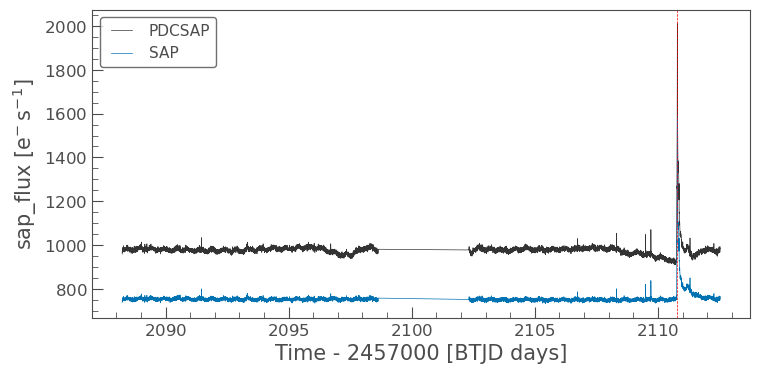

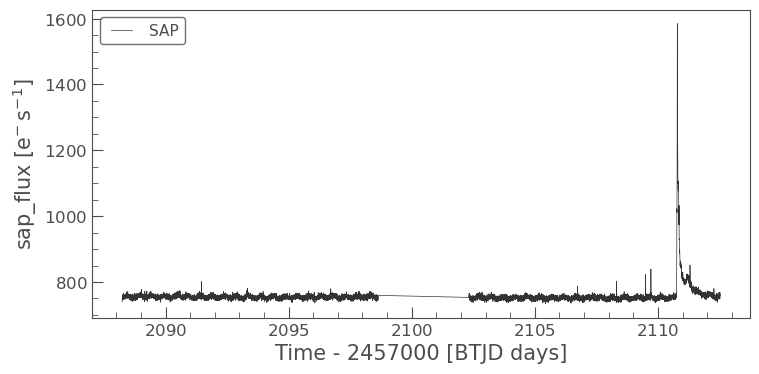

In [7]:
flare_lc = flare_lc.remove_nans()
ax = flare_lc.plot(column= 'pdcsap_flux', label="PDCSAP")
flare_lc.plot(ax=ax, column= 'sap_flux', label="SAP")
flare_lc.plot(column= 'sap_flux', label="SAP")

time_tdb = Time(flare_lc.time.value, format= flare_lc.time.format, scale= flare_lc.time.scale)
time_utc = time_tdb.utc.mjd
flare_start_idx = np.abs(time_utc-flare['mjd']).argmin()
print(flare_start_idx, time_utc[flare_start_idx], flare_lc.time.value[flare_start_idx])
ax.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')

For Pike, appears that PDCSAP processing didn't know how to account for the flare resulting in significant data artifacts. So using SAP Flux.

## Removing Quiescent Behaviors

Dominant Frequency: 0.00824 1 / d <-> Dominant Period: 121.41090 d -> Max Power: 10.39113 electron / s


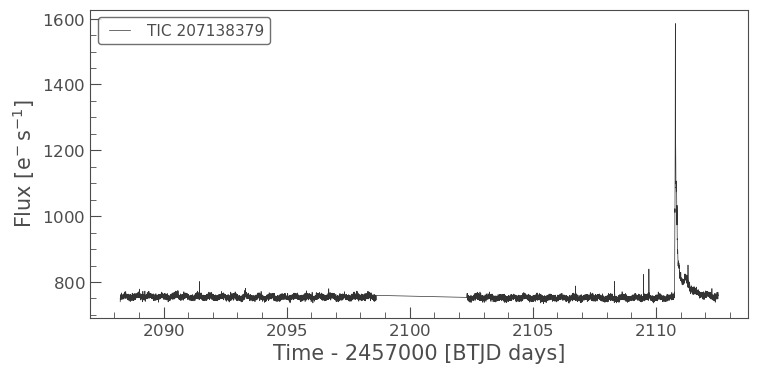

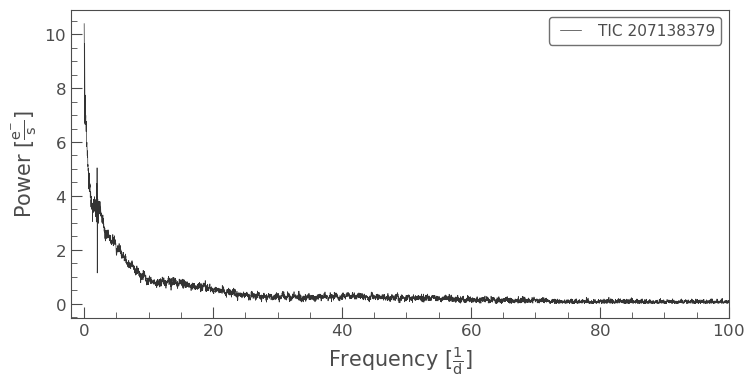

In [8]:
flare_lc = flare_lc.select_flux('sap_flux')
flare_lc.plot()
p = flare_lc.to_periodogram('ls')
ax = p.plot()
ax.set_xlim(-2,100)
ax.plot()
print(f'Dominant Frequency: {p.frequency_at_max_power:.5f} <-> Dominant Period: {p.period_at_max_power:.5f} -> Max Power: {p.max_power:.5f}')


### AltaiPony

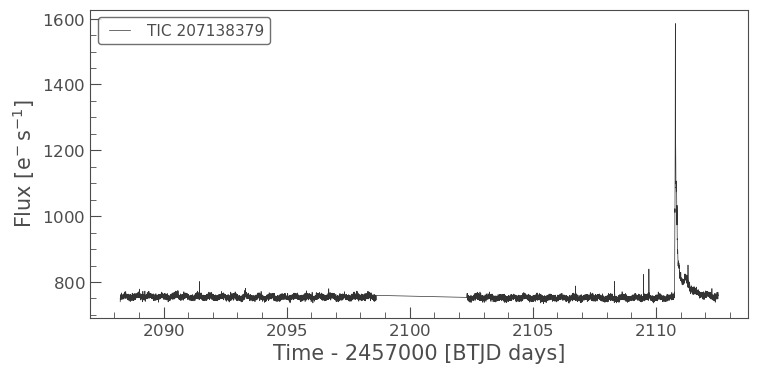

In [ ]:
flc = FlareLightCurve(flare_lc)
ax = flc.plot()

window length: 71.0
window length: 71.0


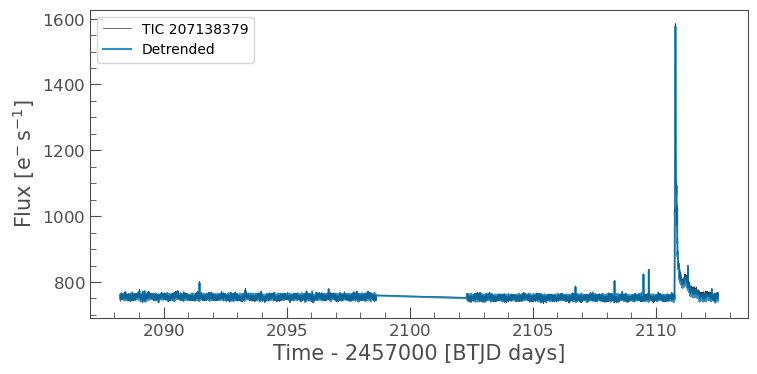

In [12]:
flc = flc.detrend(mode= 'savgol', printwl= True)
ax = flc.plot()
ax.plot(flc.time.value, flc.detrended_flux.value, label='Detrended', alpha= 0.8)
ax.legend()
# ax.set_ylim(700, 800)
plt.show()

In [13]:
flc = flc.find_flares(addtail=True, tailthreshdiff = 1.5)
flc.flares

Found 1 candidate(s) in the (0,7469) gap.
Found 7 candidate(s) in the (7469,14780) gap.
c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\altaipony\altai.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc.flares = pd.concat([lc.flares, new], ignore_index=True)


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,2311,2317,622083,622089,2091.461351,2091.469685,20.426116,1.547769,0.056476,0.008333,14780.0
1,10626,10635,633078,633087,2106.732347,2106.744847,25.327767,1.926805,0.042239,0.012500,14780.0
2,12601,12606,635066,635071,2109.493469,2109.500414,22.976824,1.273104,0.093081,0.006944,14780.0
3,12760,12767,635225,635232,2109.714303,2109.724026,49.137866,1.685525,0.108221,0.009722,14780.0
4,13510,13981,635977,636448,2110.758750,2111.412918,7614.657727,10.863436,1.094522,0.654168,14780.0
5,13993,14030,636460,636498,2111.429584,2111.482362,105.579758,4.532312,0.036731,0.052778,14780.0
6,14119,14127,636587,636595,2111.605973,2111.617085,18.591048,2.118228,0.025959,0.011111,14780.0
7,14138,14153,636606,636621,2111.632362,2111.653196,43.444137,2.935490,0.031392,0.020833,14780.0


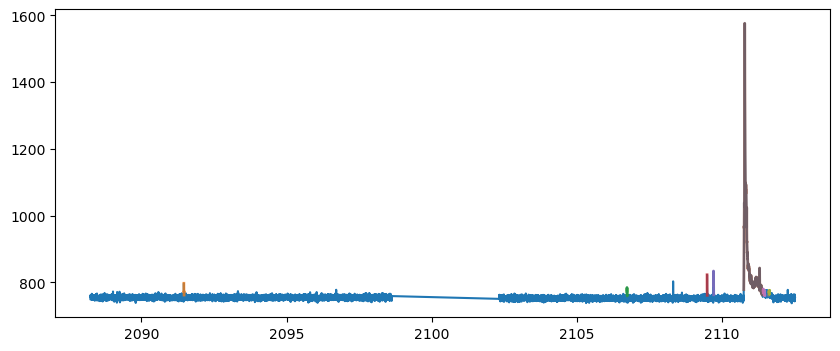

In [14]:
f, ax = plt.subplots(1,1, figsize= (10,4))
ax.plot(flc.time.value, flc.detrended_flux.value)
for flare in flc.flares.iterrows():
    flare = flare[1]
    istart = flare['istart']
    istop = flare['istop']
    ax.plot(flc.time.value[istart:istop], flc.detrended_flux.value[istart:istop], alpha= 0.75, linewidth= 2)

# Other Tests

### ~~Lightkurve flatten~~
Does not work as no window_length captures quiescent trend without also capturing the flare and masking out flare does not generate a trend over the flare interval to subtract.

First plan is to remove periodic oscillations.
Convert to periodigram with lk.to_periodigram('ls') <- we want to use lomb-scargle since our periodic behavior is not necessarily a transient (in Andy(s) case its a binary).
Then to use flatten correctly to remove lower frequencies, we need to...
- Mask out flare
- Identify adequate break tolerance value
- How to avoid sigma clipping of flare? (maybe mask will do this)

In [ ]:
flare_mask = (time_utc > flare['mjd']-0.5) & (time_utc < flare['mjd']+1.5)

ax = flare_lc.plot()
ax.plot(flare_lc.time.value[flare_mask], flare_lc.flux.value[flare_mask])

In [ ]:
flattened, trend = flare_lc.flatten(window_length= 15, return_trend= True, break_tolerance= 3, mask= flare_mask)
flattened.plot(label= 'flattened')
trend.plot(label= 'trend')

### Wotan?

### My Methods

Clean data:
- Cut out flare
- identify how to inter/extrapolate?

#### numpy fft

In [ ]:
def fit_with_numpyfft(time, flux, flare_start_idx):
    fit_time = time[:flare_start_idx]
    fit_flux = flux[:flare_start_idx]

    porb= 2

    fft_coeffs = np.fft.fft(fit_flux)
    freq = np.fft.fftfreq(len(fit_time), d= (fit_time[1] - fit_time[0]))

    # restrict terms to those above orbital frequency
    valid_freq_ids = np.where(np.abs(freq) < 1/porb)[0]
    print(np.min(1/np.abs(freq[valid_freq_ids])))
    filtered_fft = np.zeros_like(fft_coeffs)
    filtered_fft[valid_freq_ids] = fft_coeffs[valid_freq_ids]
    print(len(freq), len(valid_freq_ids))

    model_flux = np.fft.ifft(fft_coeffs).real

    extrapolated_flux = np.zeros_like(time)
    for i,fr in enumerate(valid_freq_ids):#valid_freq_ids:
        amplitude = np.abs(fft_coeffs[i]) / len(fit_time)
        phase = np.angle(fft_coeffs[i])
        extrapolated_flux += amplitude * np.cos(2 * np.pi * fr * (time - time[0]) + phase)

    return model_flux, extrapolated_flux
    

In [ ]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.15)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")

ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax2.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax2.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax2.legend()
ax2.set_title("Full Extrapolated Numpy FFT")

ax3 = fig.add_subplot(gs[1,0])
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")

plt.tight_layout()

#### Fit Polynomial

In [ ]:
t = time[500:915] - np.mean(time[500:915])
flux = sap_flux[500:915]
flux_cut = np.where(flux < 974)
t = t[flux_cut]
flux = flux[flux_cut]

order = 12
def nth_order_poly(x, *coeffs):
    result = 0
    for i, c in enumerate(coeffs):
        result += c*x**i
    return result

initial_guess = np.zeros(order+1)
initial_guess[0] = 962.5

popt, pcov = curve_fit(lambda x, *params: nth_order_poly(x, *params), t, flux, p0= initial_guess)
print(popt)

y = lambda x: nth_order_poly(x, *popt)

plt.scatter(t, flux, s=1)
plt.plot(t, y(t))

#### Cosine Transform Fit
Fails as cosine basis fit with finite terms will only fit well within fit duration, but we must extrapolate to approximate flux during flare.

In [ ]:
def cosine_transform_fit(time, flux, Porb):
    fit_time = time[:flare_start]
    fit_flux = flux[:flare_start]
    T = fit_time[-1] - fit_time[0]
    N = round((2 * T) / (Porb))
    print(N)

    def cosine_basis(t, i):
        return np.cos((2 * np.pi / (2 * T)) * i * t)
    # Create the design matrix using the cosine basis functions
    A = np.array([cosine_basis(fit_time, i) for i in range(0, N+1)]).T
    # Solve for the linear coefficients using least squares
    coeffs, _, _, _ = lstsq(A, fit_flux)
    # Calculate the model flux
    model_flux = np.dot(A, coeffs)

    A_full = np.array([cosine_basis(time, i) for i in range(0, N+1)]).T
    full_model_flux = np.dot(A_full, coeffs)

    return model_flux, full_model_flux

In [ ]:
modulations, fitted_modulations = cosine_transform_fit(time, sap_flux, porb)

# plt.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='original flux')
# plt.plot(time[:flare_start], modulations, c= 'orange', label='modulation')
plt.plot(time, sap_flux, c= 'b', label='original flux')
plt.plot(time, fitted_modulations, c= 'orange', label='fitted flux')
plt.legend()

# Plotting to keep in back pocket

In [ ]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")


gs_sub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 1], wspace=0.4)
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2_1 = fig.add_subplot(gs_sub[0,0])
ax2_1.scatter(time[:flare_start], sap_flux[:flare_start], s= 1, c= 'b', label='Original flux')
ax2_1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT')
ax2_1.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_1.set_xlim(time[0], time[750])
ax2_1.spines.right.set_visible(False)
ax2_1.yaxis.tick_left()
ax2_1.plot([1, 1], [0, 1], transform=ax2_1.transAxes, **kwargs)

ax2_2 = fig.add_subplot(gs_sub[0,1])
ax2_2.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='Original flux')
ax2_2.plot(time[:flare_start], modulations[:flare_start], c= 'r', label='Standard FFT')
ax2_2.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_2.legend()
ax2_2.set_xlim(time[flare_start -750], time[flare_start])
ax2_2.spines.left.set_visible(False)
ax2_2.yaxis.tick_right()
ax2_2.tick_params(labelright= False)
ax2_2.plot([0, 0], [0, 1], transform=ax2_2.transAxes, **kwargs)

fig.text(0.73, 0.89, "Zoomed View of Fit Quality (Before Flare)", ha='center', fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter(time[:flare_start], fitted_modulations[:flare_start] - modulations, s= 1, c= 'orange', label= 'Extrapolation Error')
ax4.legend()
ax4.set_title("Residuals (before flare)")

plt.tight_layout()